# Dance Form Image Classification - Transfer Learning & Regularization

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
%matplotlib inline

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Borivali National Park'   Datasets.zip       Recovery
 class_Assignments	   images	      Screencastify
 class_Programs		   my_Programs	      yolov3
'Colab Notebooks'	   Networking	      Youtube_PYProject
 daily_coding		   onlinesale.zip
 dance-form.zip		   Project_Momentos


In [ ]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/dance-form.zip /content

In [ ]:
# unzip the zip file 
# !unzip dance-form.zip
!unzip /content/dance-form.zip -d /content

Archive:  /content/dance-form.zip
   creating: /content/dataset/
   creating: /content/dataset/test/
  inflating: /content/dataset/test/508.jpg  
  inflating: /content/dataset/test/246.jpg  
  inflating: /content/dataset/test/473.jpg  
  inflating: /content/dataset/test/485.jpg  
  inflating: /content/dataset/test/128.jpg  
  inflating: /content/dataset/test/410.jpg  
  inflating: /content/dataset/test/465.jpg  
  inflating: /content/dataset/test/196.jpg  
  inflating: /content/dataset/test/340.jpg  
  inflating: /content/dataset/test/467.jpg  
  inflating: /content/dataset/test/306.jpg  
  inflating: /content/dataset/test/171.jpg  
  inflating: /content/dataset/test/323.jpg  
  inflating: /content/dataset/test/332.jpg  
  inflating: /content/dataset/test/330.jpg  
  inflating: /content/dataset/test/170.jpg  
  inflating: /content/dataset/test/479.jpg  
  inflating: /content/dataset/test/9.jpg  
  inflating: /content/dataset/test/283.jpg  
  inflating: /content/dataset/test/114.jpg  
 

## Preparing the Data

In [ ]:
DATA_DIR = '/content/dataset'

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'                             

TRAIN_CSV = DATA_DIR + '/train.csv'                       
TEST_CSV = DATA_DIR + '/test.csv'   

In [ ]:
# train_df = pd.read_csv(TRAIN_CSV)
# test_df = pd.read_csv(TEST_CSV)
# test_df.head()
# train_df.head()
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()
test_df = pd.read_csv(TEST_CSV)
test_df['target'] = [0]*156
test_df.to_csv('/content/dataset/test.csv', index=False)
img = Image.open(DATA_DIR + '/train/163.jpg')
plt.imshow(img)
print(len(test_df))

NameError: ignored

In [ ]:
labels = [
    'manipuri',
    'bharatanatyam',
    'odissi',
    'kathakali',
    'kathak',
    'sattriya',
    'kuchipudi',
    'mohiniyattam',
]
# targets = [0,1,2,3,4,5,6,7]

In [ ]:
k=0
for i in data_df.loc:
    data_df.loc[k]['target']=labels.index(i[1])
    k +=1

KeyError: ignored

In [ ]:
data_df.head()

,Image,target
0,96.jpg,0
1,163.jpg,1
2,450.jpg,2
3,219.jpg,3
4,455.jpg,2


In [ ]:
def encode_label(label):
    target = torch.zeros(8)
    target[labels[label]] = 1.
    return target

# def decode_target(target, text_labels=False, threshold=0.5):
#     result = []
#     for i, x in enumerate(target):
#         if (x >= threshold):
#             if text_labels:
#                 result.append(labels[i] + "(" + str(i) + ")")
#             else:
#                 result.append(str(i))
#     return ' '.join(result)

In [ ]:
class danceDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'],row['target']
        # print(img_id, img_label)
        img_fname = self.root_dir + "/" + str(img_id)
        img = Image.open(img_fname)
        # plt.show(img)
        if self.transform:
            img = self.transform(img)
        return img,img_label

### Data augmentations

In [ ]:
# imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.Resize((512,512)),                  
    # T.RandomCrop(512, padding=1, padding_mode='reflect'),
    # T.RandomResizedCrop(512, scale=(0.5,0.9), ratio=(1, 1)), 
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # T.RandomHorizontalFlip(), 
    # T.RandomRotation(10),
    T.ToTensor(), 
#     T.Normalize(*imagenet_stats,inplace=True), 
    # T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize((512,512)), 
    T.ToTensor(), 
#     T.Normalize(*imagenet_stats)
])

In [ ]:
# train_ds = ImageFolder(DATA_DIR +'/train', train_tfms)
# valid_ds = ImageFolder(DATA_DIR +'/test', valid_tfms)

In [ ]:
np.random.seed(42)
y = len(data_df)
print(y)
msk = np.random.rand(len(data_df)) < 0.9
# print(msk)
train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()
print(len(val_df))
print(train_df.loc[1]['target'])

364
33
2


In [ ]:
train_ds = danceDataset(train_df, TRAIN_DIR, transform=train_tfms)
valid_ds = danceDataset(val_df, TRAIN_DIR, transform=valid_tfms)
# len(train_ds), len(valid_ds)
# print(type(train_ds),type(valid_ds))
# u, o = train_ds[56]
# print(u.shape)
len(train_ds), len(valid_ds)
print(train_ds)
print(*train_ds[1])

tensor([[[0.0667, 0.0667, 0.0706,  ..., 0.0667, 0.0667, 0.0667],
         [0.0667, 0.0667, 0.0706,  ..., 0.0667, 0.0667, 0.0667],
         [0.0667, 0.0667, 0.0706,  ..., 0.0627, 0.0627, 0.0627],
         ...,
         [0.0431, 0.0431, 0.0431,  ..., 0.0235, 0.0235, 0.0235],
         [0.0392, 0.0392, 0.0392,  ..., 0.0235, 0.0235, 0.0235],
         [0.0353, 0.0353, 0.0392,  ..., 0.0235, 0.0235, 0.0235]],

        [[0.0627, 0.0627, 0.0667,  ..., 0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0667,  ..., 0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0667,  ..., 0.0588, 0.0588, 0.0588],
         ...,
         [0.0471, 0.0471, 0.0471,  ..., 0.0275, 0.0275, 0.0275],
         [0.0431, 0.0431, 0.0431,  ..., 0.0275, 0.0275, 0.0275],
         [0.0392, 0.0392, 0.0431,  ..., 0.0275, 0.0275, 0.0275]],

        [[0.0471, 0.0471, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
         [0.0471, 0.0471, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
         [0.0471, 0.0471, 0.0510,  ..., 0.0431, 0.0431, 0.

In [ ]:
def show_sample(img, target, invert=False):
    # print(img.shape)
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute((1, 2, 0)))
    print('Labels:', target)

Labels: 3


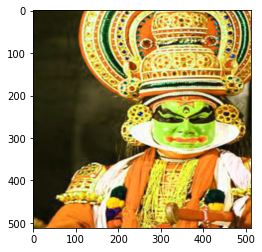

In [ ]:
show_sample(*train_ds[2])

### DataLoaders

In [ ]:
batch_size = 8

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True,num_workers=3, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size*2,num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        print(labels)
        print(type(labels))
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

tensor([3, 5, 5, 5, 7, 0, 1, 7])
<class 'torch.Tensor'>


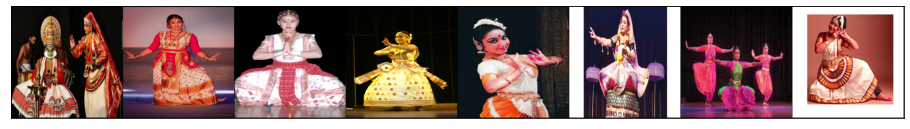

In [ ]:
show_batch(train_dl)

## Model - Transfer Learning

In [ ]:
# from sklearn import preprocessing
# label_encoder = preprocessing.LabelEncoder()
# data['Country']= label_encoder.fit_transform(data[‘Country']) 

def F_score(output, label, threshold=0.5, beta=1):
    print(output)
    print(label)
    # print(type(output))
    # print(type(label))
    ouput = F.softmax(output, dim=1)
    prob = output > threshold
    target = torch.zeros(8)
    target[labels[label]] = 1.
    label = target
    label = label > threshold
    print("probability ",prob)
    print("label",label)

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

def accuracy(outputs, labs):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labs).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        # epoch_loss = sum(batch_losses)//len(batch_losses)
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        # epoch_score = sum(batch_scores)//len(batch_scores)
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

    # def epoch_end(self, epoch, result):
    #     print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
    #         epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

[Learn about ResNets.](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

Check out torchvision models: https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
bot = models.densenet161()
bot

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
class AppliedModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.densenet161(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs,1024)
        self.linear1 = nn.Linear(1024,512)
        self.linear2 = nn.Linear(512,8)
    
    def forward(self, xb):
        # print(F.softmax(out, dim=1))
        out = self.network(xb)
        out = F.relu(out)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)

        return out
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.classifier.parameters():
            param.require_grad = True
        # for param in self.network.avgpool.parameters():
        #     param.require_grad = True
        # for param in self.network.layer4.parameters():
        #     param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    # print(type(data))
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    # print("to_device",type(data))
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            # print("Devicedataloader",b) 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
# for b in train_dl:
#   print(b)

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
print(train_dl)

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

## Training

In [ ]:
# print(type(SimpleResidualBlock()))
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

NameError: ignored

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def fit_(epochs, lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(),lr,weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
    #                                             steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            # sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        # result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history




def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # clears any cache memory in the GPU
    history = []
    optimizer = opt_func(model.parameters(), lr)

#one epoch means one full cycle wherein the model is trained by all the dataset batchwise
    for epoch in range(epochs):
        # Training Phase 
        model.train() #training mode
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() # gradients are calculated
            optimizer.step() # weights and bias are updated
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(AppliedModel(), device)
# model

In [ ]:
# print(type(device))
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.0773115158081055, 'val_score': 0.1041666641831398}]

First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [ ]:
model.freeze()

In [ ]:
# epochs = 15
# max_lr = 0.01
grad_clip = 0.001
weight_decay = 1e-6
# opt_func = torch.optim.Adam
# opt_func = torch.optim.SparseAdam

In [ ]:
# # %%time
# history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
#                          grad_clip=grad_clip, 
#                          weight_decay=weight_decay, 
#                          opt_func=opt_func)

In [ ]:
history += fit(10,1e-2, model,train_dl, val_dl)


Epoch [0], train_loss: 1.4740, val_loss: 1.3520, val_score: 0.3333



Epoch [1], train_loss: 1.2960, val_loss: 1.2384, val_score: 0.7083



Epoch [2], train_loss: 1.1924, val_loss: 1.0649, val_score: 0.7292



Epoch [3], train_loss: 1.0296, val_loss: 0.9079, val_score: 0.7083



Epoch [4], train_loss: 0.8626, val_loss: 0.7143, val_score: 0.7708



Epoch [5], train_loss: 0.7260, val_loss: 0.7163, val_score: 0.7708



Epoch [6], train_loss: 0.6782, val_loss: 0.5605, val_score: 0.7917



Epoch [7], train_loss: 0.6489, val_loss: 0.4705, val_score: 0.7917



Epoch [8], train_loss: 0.5249, val_loss: 0.3576, val_score: 0.8958



Epoch [9], train_loss: 0.5107, val_loss: 0.5523, val_score: 0.7708


In [ ]:
history += fit(3,1e-2, model,train_dl, val_dl)


Epoch [0], train_loss: 0.3606, val_loss: 0.3257, val_score: 0.8750



Epoch [1], train_loss: 0.3228, val_loss: 0.4379, val_score: 0.8333



Epoch [2], train_loss: 0.2938, val_loss: 0.2509, val_score: 0.9167


In [ ]:
history += fit(3,1e-12, model,train_dl,val_dl)


Epoch [0], train_loss: 0.1836, val_loss: 0.3030, val_score: 0.9167



Epoch [1], train_loss: 0.2089, val_loss: 0.2743, val_score: 0.9167



Epoch [2], train_loss: 0.2304, val_loss: 0.2852, val_score: 0.9167


Now, unfreeze and train some more.

In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
train_time='22:00'

In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

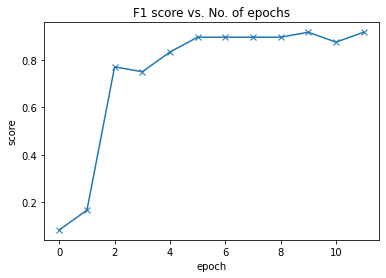

In [ ]:
plot_scores(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

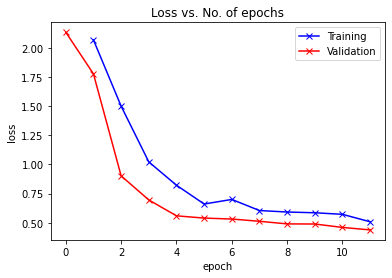

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

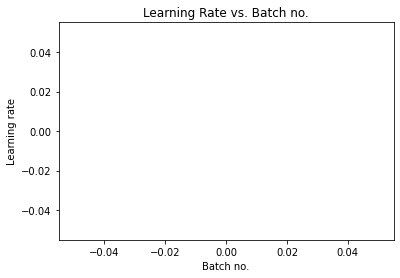

In [ ]:
plot_lrs(history)

## Making predictions and submission

In [ ]:
# def predict_single(image):
#     xb = image.unsqueeze(0)
#     xb = to_device(xb, device)
#     preds = model(xb)
#     prediction = preds[0]
#     print("Prediction: ", prediction)
#     show_sample(image, prediction)

def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    outputs = model(xb) 
    _, preds = torch.max(outputs, dim=1)
    prediction = preds[0]
    print("Prediction: ", preds)
    show_sample(image, prediction)

In [ ]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = danceDataset(test_df, TEST_DIR, transform=valid_tfms)

In [ ]:
img, target = test_dataset[0]
img.shape

AttributeError: ignored

Prediction:  tensor([3], device='cuda:0')
Labels: tensor(3, device='cuda:0')


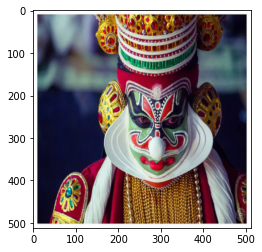

In [ ]:
predict_single(test_dataset[7][0])

Prediction:  tensor([4], device='cuda:0')
Labels: tensor(4, device='cuda:0')


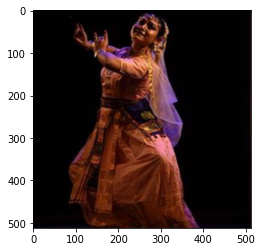

In [ ]:
predict_single(test_dataset[87][0])

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        # probs = model(xb)
        outputs = model(xb) 
        _, preds = torch.max(outputs, dim=1)
        batch_probs.append(preds.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [labels[x] for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
submission_df['target'] = test_preds
submission_df.sample(20)

,Image,target
133,363.jpg,odissi
69,145.jpg,bharatanatyam
107,392.jpg,kuchipudi
129,498.jpg,odissi
123,291.jpg,mohiniyattam
63,162.jpg,kuchipudi
18,283.jpg,mohiniyattam
74,447.jpg,odissi
139,33.jpg,kathak
92,67.jpg,kathak


In [ ]:
sub_fname = '/content/submission.csv'

In [ ]:
submission_df.to_csv(sub_fname, index=False)

## Save and Commit

In [ ]:
weights_fname = 'dance-form-vgg16.pth'
torch.save(model.state_dict(), weights_fname)

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet34', 
                       epochs=2*epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_score=history[-1]['val_score'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

In [ ]:
project_name='protein-advanced'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])